In [1]:
from sklearn.multiclass import OneVsRestClassifier    #also known as one-vs-all classifiers
from sklearn.svm import LinearSVC
import numpy as np
from PIL import Image
from glob import glob
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
def get_feature(image):
    step=4
    if image.size != (256, 256):
        image = image.resize((256, 256))
    feature = np.zeros((63, 63, 64))
    image = np.array(image)
    for i in range(63):
        for j in range(63):
            vector = image[i*step:i*step+8, j*step:j*step+8].flatten()
            vector = (vector - np.mean(vector))/np.std(vector)
            np.seterr(divide='ignore', invalid='ignore')
            feature[i, j] = vector
    feature = np.nan_to_num(feature)
    return feature.reshape((-1,64))

In [7]:
def get_category():
    training_path = r'E:/桌面文件/Shool Work/Master/Semester Two/COMP6223/Coursework/Coursework Three/Coursework3/training'
    category = os.listdir(training_path)
    if category.__contains__('.DS_Store'):
        category.remove('.DS_Store')
    return category

def get_path(t='train', c='Forest'):
    training_path = r'E:/桌面文件/Shool Work/Master/Semester Two/COMP6223/Coursework/Coursework Three/Coursework3/training'
    testing_path = r'E:/桌面文件/Shool Work/Master/Semester Two/COMP6223/Coursework/Coursework Three/Coursework3/testing'
    if t == 'train':
        return glob(os.path.join(training_path, c, '*.jpg'))
    if t == 'test':
        return glob(os.path.join(testing_path, '*.jpg'))

In [8]:
#Get all train image
category = get_category()
print(category)
X_train_image = []
Y_label = []
for c in category:
    train_path = get_path('train', c)
    for path in train_path:
        image = Image.open(path)
        X_train_image.append(image)
        Y_label.append(c)
    print('{} Completed!'.format(c))

['bedroom', 'Coast', 'Forest', 'Highway', 'industrial', 'Insidecity', 'kitchen', 'livingroom', 'Mountain', 'Office', 'OpenCountry', 'store', 'Street', 'Suburb', 'TallBuilding']
bedroom Completed!
Coast Completed!
Forest Completed!
Highway Completed!
industrial Completed!
Insidecity Completed!
kitchen Completed!
livingroom Completed!
Mountain Completed!
Office Completed!
OpenCountry Completed!
store Completed!
Street Completed!
Suburb Completed!
TallBuilding Completed!


In [5]:
print(type(X_train_image[0]))
print(type(Y_label))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'list'>


In [9]:
le = preprocessing.LabelEncoder()#number the label
le.fit(Y_label)
train_y = le.transform(Y_label)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_image,Y_label,test_size=0.2, random_state=4)

In [15]:
OVR = OneVsRestClassifier(LinearSVC(dual=False))

In [39]:
NUM_CLUSTERS = 1900
SAMPLE_SIZE = 1900
accuracy_train =[]
accuracy_val = []
while NUM_CLUSTERS<2000:
    if NUM_CLUSTERS > SAMPLE_SIZE:
        SAMPLE_SIZE += 200
    else:
        while SAMPLE_SIZE<2400:
            OVR = OneVsRestClassifier(LinearSVC(dual=False))
            kmeans = MiniBatchKMeans(n_clusters=NUM_CLUSTERS)
            bagging = BaggingClassifier(OVR, n_estimators=15)
            count = 0
            X = []
            for image in X_train: #get fetures of training data
                feature = get_feature(image)
                mid = len(feature)/2
                samples = feature[int(mid-SAMPLE_SIZE/2) : int(mid+SAMPLE_SIZE)]
                samples = np.nan_to_num(samples)
                X.append(samples)
                count +=1
                del feature
                del samples
                if count%100 ==0:
                    print('NUM_CLUSTERS{} SAMPLE_SIZE{} Part one{} Completed!'.format(NUM_CLUSTERS,SAMPLE_SIZE, count))
            count = 0
            X = np.array(X)
            nsamples, nx, ny = X.shape
            input_samples = X.reshape((nsamples*nx, ny))
            kmeans.fit(input_samples)
            X_train_new=[]
            for image in X_train: #get 80% training data to train
                feature = get_feature(image)
                res = kmeans.predict(feature)
                X_train_new.append(res)
                count += 1
                if count%100 == 0:
                    print('NUM_CLUSTERS{} SAMPLE_SIZE{} Part Two{} Completed!'.format(NUM_CLUSTERS,SAMPLE_SIZE, count))
            count = 0
            OVR.fit(X_train_new,y_train)
            X_new_val=[]
            for image in X_val:#get 20% training data to validate
                feature = get_feature(image)
                res = kmeans.predict(feature)
                X_new_val.append(res)
                count += 1
                if count%100 == 0:
                    print('NUM_CLUSTERS{} SAMPLE_SIZE{} Part Three{} Completed!'.format(NUM_CLUSTERS,SAMPLE_SIZE, count))
            count = 0
            #compute the accuracy
            y_predict_train = OVR.predict(X_train_new)
            y_predict_val = OVR.predict(X_new_val)
            acc_train = accuracy_score(y_train,y_predict_train)
            acc_val = accuracy_score(y_val,y_predict_val)
            accuracy_train.append(acc_train)
            accuracy_val.append(acc_val)
            print('NUM_CLUSTERS{} SAMPLE_SIZE{} accuracy(train,val):'.format(NUM_CLUSTERS,SAMPLE_SIZE),acc_train,acc_val)
            SAMPLE_SIZE += 200
        SAMPLE_SIZE = 1900
    NUM_CLUSTERS += 200 
    print('-------new turn---------')

NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one100 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one200 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one300 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one400 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one500 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one600 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one700 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one800 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one900 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one1000 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one1100 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part one1200 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part Two100 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part Two200 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part Two300 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part Two400 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part Two500 Completed!
NUM_CLUSTERS1900 SAMPLE_SIZE1900 Part Two600 

In [98]:
acc_train_1 = accuracy_train# 500 ,[500:2100:200]
acc_val_1 =accuracy_val
new = [i+0.3 for i in acc_val_1]
print(new)

[0.44333333333333336, 0.45999999999999996, 0.4666666666666667, 0.42666666666666664, 0.38666666666666666]


In [49]:
acc_train_2 = accuracy_train
acc_val_2 =accuracy_val
print(acc_val_2)

[0.13, 0.15333333333333332, 0.13333333333333333, 0.16333333333333333, 0.13, 0.16, 0.12666666666666668, 0.14666666666666667]


In [52]:
acc_train_3 = accuracy_train
acc_val_3 =accuracy_val#900
print(acc_val_3)

[0.13, 0.15, 0.15666666666666668, 0.12, 0.16333333333333333, 0.07666666666666666, 0.12333333333333334]


In [55]:
acc_train_4 = accuracy_train
acc_val_4 =accuracy_val
print(acc_val_4)#1100

[0.13333333333333333, 0.15, 0.12, 0.12666666666666668, 0.13666666666666666, 0.14333333333333334, 0.16666666666666666]


In [57]:
acc_train_5 = accuracy_train#1300
acc_val_5 =accuracy_val
print(acc_val_5)

[0.14666666666666667, 0.14666666666666667, 0.15333333333333332, 0.18, 0.12, 0.15]


In [59]:
acc_train_6 = accuracy_train#1500
acc_val_6 =accuracy_val
print(acc_val_6)

[0.13666666666666666, 0.12666666666666668, 0.14666666666666667, 0.15, 0.14666666666666667]


In [61]:
acc_train_7 = accuracy_train
acc_val_7 =accuracy_val#1700
print(acc_val_7)

[0.11666666666666667, 0.13666666666666666, 0.15333333333333332, 0.13]


In [65]:
acc_train_8= accuracy_train#1900:2300
acc_val_8 =accuracy_val
print(acc_val_8)

[0.14333333333333334, 0.16, 0.16666666666666666, 0.12666666666666668, 0.08666666666666667]


In [15]:
acc_val_1 =[0.13, 0.15333333333333332, 0.14333333333333333, 0.16333333333333333, 0.13, 0.16, 0.12666666666666668, 0.14666666666666667]
acc_val_2 =[0.13, 0.15333333333333332, 0.13333333333333333, 0.16333333333333333, 0.13, 0.16, 0.12666666666666668, 0.14666666666666667]
acc_val_3 =[0.13, 0.15, 0.15666666666666668, 0.12, 0.16333333333333333, 0.07666666666666666, 0.12333333333333334]
acc_val_4 =[0.13333333333333333, 0.15, 0.12, 0.12666666666666668, 0.13666666666666666, 0.14333333333333334, 0.16666666666666666]
acc_val_5 =[0.14666666666666667, 0.14666666666666667, 0.15333333333333332, 0.22, 0.12, 0.15]
acc_val_6 =[0.13666666666666666, 0.12666666666666668, 0.14666666666666667, 0.15, 0.14666666666666667]
acc_val_7 =[0.11666666666666667, 0.13666666666666666, 0.15333333333333332, 0.13]
acc_val_8 =[0.14333333333333334, 0.16, 0.16666666666666666, 0.12666666666666668, 0.08666666666666667]

3


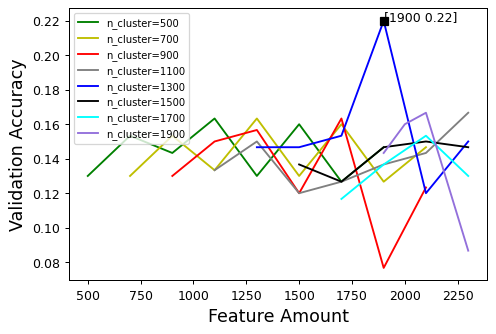

In [16]:
import matplotlib.pyplot as plt
plt.figure(dpi=90)
plt.xlabel('Feature Amount', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.plot(range(500,2100,200), acc_val_1, c='g', label='n_cluster=500')
plt.plot(range(700,2300,200), acc_val_2, c='y', label='n_cluster=700')
plt.plot(range(900,2300,200), acc_val_3, c='r', label='n_cluster=900')
plt.plot(range(1100,2500,200), acc_val_4, c='gray', label='n_cluster=1100')
plt.plot(range(1300,2500,200), acc_val_5, c='blue', label='n_cluster=1300')
plt.plot(range(1500,2500,200), acc_val_6, c='black', label='n_cluster=1500')
plt.plot(range(1700,2500,200), acc_val_7, c='cyan', label='n_cluster=1700')
plt.plot(range(1900,2400,100), acc_val_8, c='mediumpurple', label='n_cluster=1900')
max_value = np.argmax(acc_val_5)
max_label = max_value*200+1300
print(max_value)
show_max = '['+str(max_label)+' '+str(acc_val_5[max_value])+']'
plt.plot(max_label,acc_val_5[max_value],'ks')
plt.annotate(show_max,xytext=(max_label,acc_val_5[max_value]),xy=(max_label,acc_val_5[max_value]))
plt.legend(prop={'size':8})
plt.show()

In [12]:
from sklearn.ensemble import BaggingClassifier

In [14]:
accuracy_train =[]
accuracy_val = []
NUM_CLUSTERS = 1300
SAMPLE_SIZE = 1900
idx = np.random.randint(low=0, high=3969, size=SAMPLE_SIZE)
kmeans = MiniBatchKMeans(n_clusters=NUM_CLUSTERS)
OVR = OneVsRestClassifier(LinearSVC(dual=False))
bagging = BaggingClassifier(OVR, n_estimators=15)
count = 0
X = []
for image in X_train:
    feature = get_feature(image)
    samples = np.nan_to_num(feature)
    X.append(samples)
    count +=1
    del feature
    del samples
    if count%100 ==0:
        print('NUM_CLUSTERS{} SAMPLE_SIZE{} Part one{} Completed!'.format(NUM_CLUSTERS,SAMPLE_SIZE, count))
count = 0
X = np.array(X)
nsamples, nx, ny = X.shape
input_samples = X.reshape((nsamples*nx, ny))
kmeans.fit(input_samples)
X_train_new=[]
for image in X_train:
    feature = get_feature(image)
    res = kmeans.predict(feature)
    X_train_new.append(res)
    count += 1
    if count%100 == 0:
        print('NUM_CLUSTERS{} SAMPLE_SIZE{} Part Two{} Completed!'.format(NUM_CLUSTERS,SAMPLE_SIZE, count))
count = 0
bagging.fit(X_train_new,y_train)
X_new_val=[]
for image in X_val:
    feature = get_feature(image)
    res = kmeans.predict(feature)
    X_new_val.append(res)
    count += 1
    if count%100 == 0:
        print('NUM_CLUSTERS{} SAMPLE_SIZE{} Part Three{} Completed!'.format(NUM_CLUSTERS,SAMPLE_SIZE, count))
count = 0
y_predict_train = bagging.predict(X_train_new)
y_predict_val = bagging.predict(X_new_val)
acc_train = accuracy_score(y_train,y_predict_train)
acc_val = accuracy_score(y_val,y_predict_val)
accuracy_train.append(acc_train)
accuracy_val.append(acc_val)
print('NUM_CLUSTERS{} SAMPLE_SIZE{} accuracy(train,val):'.format(NUM_CLUSTERS,SAMPLE_SIZE),acc_train,acc_val)

NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one100 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one200 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one300 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one400 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one500 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one600 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one700 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one800 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one900 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one1000 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one1100 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part one1200 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part Two100 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part Two200 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part Two300 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part Two400 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part Two500 Completed!
NUM_CLUSTERS1300 SAMPLE_SIZE1900 Part Two600 

In [19]:
test_data_base_path = "E:/桌面文件/Shool Work/Master/Semester Two/COMP6223/Coursework/Coursework Three/Coursework3/testing"
res = []
for i in range(2988):
    test_path = glob(os.path.join(test_data_base_path, '{}.jpg'.format(i)))
    if test_path != []:
        image = Image.open(test_path[0])
        feature = get_feature(image)
        pred_res = kmeans.predict(feature)
        res1 = OVR.predict(pred_res.reshape(1,-1))
        res.append(res1)
    if i%200 == 0:
        print('{} prediction completed!'.format(i))

0 prediction completed!
200 prediction completed!
400 prediction completed!
600 prediction completed!
800 prediction completed!
1000 prediction completed!
1200 prediction completed!
1400 prediction completed!
1600 prediction completed!
1800 prediction completed!
2000 prediction completed!
2200 prediction completed!
2400 prediction completed!
2600 prediction completed!
2800 prediction completed!


In [28]:
from tqdm import tqdm
filename = []
#f = glob(os.path.join(test_data_base_path, '*.jpg'))
img_path_list  = os.listdir(test_data_base_path)
img_path_list.sort(key=lambda x: int(x[:-4]))
for file in tqdm(img_path_list):
  #image = cv2.imread(test_data_base_path+'/'+file)
  filename.append(file)
  #test.append(torch.as_tensor(np.resize(np.array(image).astype(float),(1,227,227))))
  #test.append(image)

100%|██████████████████████████████████████████████████████████████████████████| 2985/2985 [00:00<00:00, 997688.85it/s]


In [37]:
with open('./run2.txt', 'w') as file:
    for i in range(len(res)):
        file.write(str(filename[i].replace(test_data_base_path+'/', '') + ' ' + res[i][0] + '\n'))
    file.close()